## Setting

- padding_flag: True (add special characters before and after sequences, e.g. 'ACTGAA' -> 'ZZ' + 'ACTGAA' + 'ZZ')
- gap_flag: True (add gapped features-- 3-mer-1-gap)
- weight_flag: False (haven't figure out how to normalise non-square matrix)
- normalised_kernel: zero-mean, unit-norm
- Sum of spectrum kernel (kmer with k = 3): (K_A + K_B + K_C)/3

## Challenging: 

- regression to mean problem
- after normalisation, kernel is still not unit variance

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

In [2]:
# Data contains both the first round result and baseline data
#
# columns: 
# AVERAGE: average value of replicates
# Group: one of 'bps', 'uni random', 'prob random', 'bandit', 'Baseline dataset'
# RBS: 20-base RBS sequences
# RBS6: 6-length RBS seq, which the [7:13] positions
# STD: standard divation of replicates
# label: normalised label (zero mean and unit variance)
#       For the first round result, label is the (GFPOD(t0 + h) - GFPOR(t0))/h,
#                                   where t0 is the turning time point
#                                         h is the time interval (e.g. 4h)
#       For the baseline data, label is the TIR used in previous paper
#       Both of the two labels express the slope, but in different scales (calculation methods are slightly different)
#       We normalise the labels as zero mean and unit variance respectively
# variable: for first round results, denote which replication is the seq. 

Path = '../../data/firstRound_4h.csv'

df = pd.read_csv(Path)
df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,bps,AGGAGA
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.844257,1.678119,1.290106,1.604161,0.284382,0.185590,bps,AGGAGA
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.674610,0.670263,0.643113,0.662662,0.017069,0.147150,bps,AGGAGA
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.986839,1.948917,1.101241,1.678999,0.500712,0.169798,bps,AGGAGA
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.830061,2.201733,0.983436,1.671743,0.624388,0.117162,bps,AGGAGA


In [3]:
df.shape

(150, 11)

Text(0.5, 1.0, 'All label')

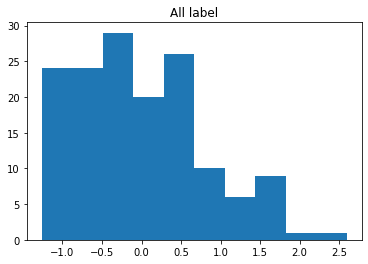

In [4]:
plt.hist(df['AVERAGE'])
plt.title('All label')

In [5]:
# data6: num_data * 2, columns: [6-base RBS seq (D), TIR labels (C)]
data = np.asarray(df[['RBS', 'AVERAGE']])

## Cross Validation

In [6]:
from sklearn.model_selection import KFold

def Train_test_split(num_data, test_size = 0.2, random_state = 24):
    np.random.seed(random_state)
    test_idx = np.random.choice(num_data, int(test_size * num_data), replace=False)
    train_idx = list(set(range(num_data)) - set(test_idx))
    
    return np.asarray(train_idx), np.asarray(test_idx)

def Train_val_split(num_data, cv = 5, random_state = 24):
    kf = KFold(n_splits = cv, shuffle = True)
    return kf.split(range(num_data))

def Generate_train_test_data(train_idx, test_idx, embedding):
    train_df = pd.melt(df.loc[train_idx], id_vars=['RBS', 'RBS6', 'AVERAGE', 'STD', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
    train_df = train_df.dropna()
    X_train = Rewards_env(np.asarray(train_df[['RBS', 'value']]), embedding).embedded
    y_train_sample = np.asarray(train_df['value'])
    y_train_ave = np.asarray(train_df['AVERAGE'])
    
    test_df = pd.melt(df.loc[test_idx], id_vars=['RBS', 'RBS6', 'AVERAGE', 'STD', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
    test_df = test_df.dropna()
    X_test = Rewards_env(np.asarray(test_df[['RBS', 'value']]), embedding).embedded
    y_test_sample = np.asarray(test_df['value'])
    y_test_ave = np.asarray(test_df['AVERAGE']) 
    
    return X_train, X_test, y_train_sample, y_test_sample, y_train_ave, y_test_ave

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

embedding = 'label'
kernel = Spectrum_Kernel
test_size = 0.2
random_state = 24
alpha_list = [0.1,0.5,1, 1.5, 2, 5]

eva_metric = r2_score

num_data = data.shape[0]
train_idx, test_idx = Train_test_split(num_data, test_size, random_state)
X_train, X_test, y_train_sample, y_test_sample, y_train_ave, y_test_ave  = Generate_train_test_data(train_idx, test_idx, embedding)

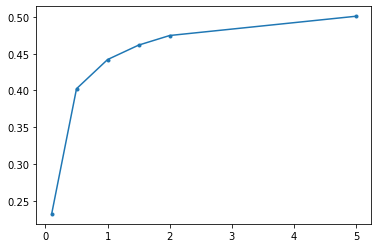

Train:  0.6199495775413286
Test:  0.68819847085891


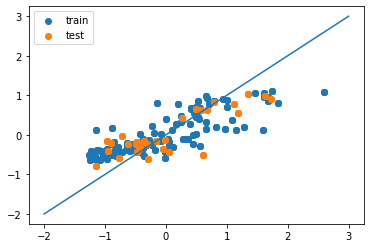

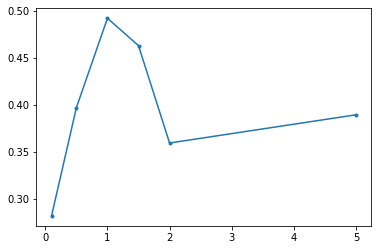

Train:  0.8678625758624481
Test:  0.04768538144226897


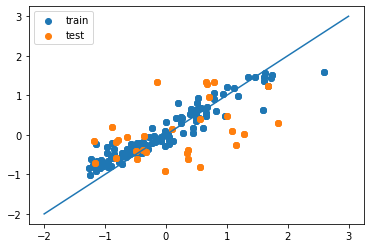

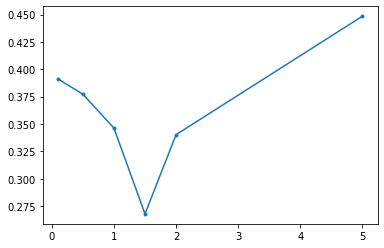

Train:  0.6628931837361449
Test:  0.330851582635046


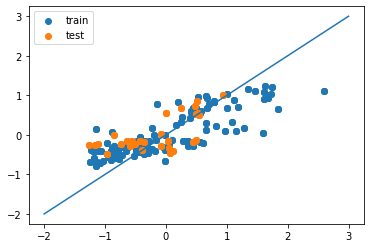

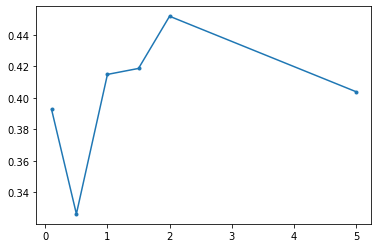

Train:  0.7635626274743355
Test:  0.5478205199807054


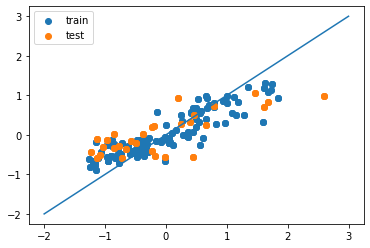

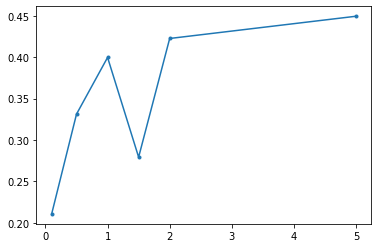

Train:  0.6996474441723799
Test:  0.12285402868644846


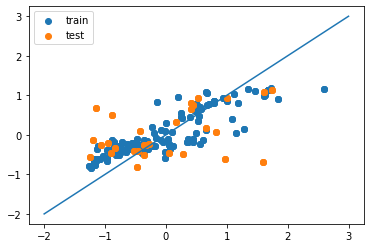

Cross-validation Test mean:  0.34748199672067576
Cross-validation Test std:  0.24365366604237


In [17]:
cv_scores = []
test_scores = []
cv = 5

# cross validation on training dataset. Find the optimal alpha. 

for train_idx, test_idx in Train_val_split(num_data, cv = cv, random_state = random_state):
    X_train, X_test, y_train_sample, y_test_sample, y_train_ave, y_test_ave  = Generate_train_test_data(train_idx, test_idx, embedding)
    cv_scores = []
    
    for alpha in alpha_list:
        scores = []
        gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = alpha)
        for train_train_idx, train_val_idx in Train_val_split(len(train_idx), cv= cv, random_state=random_state):
            X_train_train, X_train_val, y_train_train_sample, y_train_val_sample, y_train_train_ave, y_train_val_ave  = Generate_train_test_data(train_train_idx, train_val_idx, embedding)
            gp_reg.fit(X_train_train, y_train_train_sample)
            y_train_val_predict = gp_reg.predict(X_train_val)
            scores.append(eva_metric(y_train_val_ave, y_train_val_predict)) # evaluate on AVERAGE value
        #scores = cross_val_score(gp_reg, X_train, y_train, cv = cv, scoring = make_scorer(eva_metric))
        cv_scores.append(np.asarray(scores).mean())
    
    plt.plot(alpha_list, cv_scores, marker = '.')
    plt.show()

    optimal_alpha = alpha_list[np.argmax(cv_scores)]
    gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = optimal_alpha)
    gp_reg.fit(X_train,y_train_sample)
    y_train_pred = gp_reg.predict(X_train)
    y_test_pred= gp_reg.predict(X_test)

    print('Train: ', eva_metric(y_train_ave, y_train_pred))
    print('Test: ', eva_metric(y_test_ave, y_test_pred))
    test_scores.append(eva_metric(y_test_ave, y_test_pred))

    plt.scatter(y_train_ave, y_train_pred, label = 'train')
    plt.scatter(y_test_ave, y_test_pred, label = 'test')
    plt.legend()
    plt.plot([-2, 3], [-2,3])
    plt.show()
    
print('Cross-validation Test mean: ', np.asarray(test_scores).mean())
print('Cross-validation Test std: ', np.asarray(test_scores).std())

Train:  0.6996474441723799
Test:  0.12285402868644846


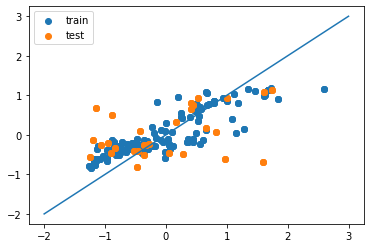

In [22]:
optimal_alpha = alpha_list[np.argmax(cv_scores)]
gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = optimal_alpha)
gp_reg.fit(X_train,y_train_sample)
y_train_pred = gp_reg.predict(X_train)
y_test_pred= gp_reg.predict(X_test)

print('Train: ', eva_metric(y_train_ave, y_train_pred))
print('Test: ', eva_metric(y_test_ave, y_test_pred))

plt.scatter(y_train_ave, y_train_pred, label = 'train')
plt.scatter(y_test_ave, y_test_pred, label = 'test')
plt.legend()
plt.plot([-2, 3], [-2,3])

In [10]:
# cross validation using all data. Show test error

scores = []
gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = optimal_alpha)
for train_train_idx, train_val_idx in Train_val_split(num_data, cv= cv, random_state=random_state):
    X_train_train, X_train_val, y_train_train_sample, y_train_val_sample, y_train_train_ave, y_train_val_ave  = Generate_train_test_data(train_train_idx, train_val_idx, embedding)
    gp_reg.fit(X_train_train, y_train_train_sample)
    y_train_val_predict = gp_reg.predict(X_train_val)
    scores.append(eva_metric(y_train_val_ave, y_train_val_predict))

print('Mean:', np.asarray(scores).mean())
print('STD:', np.asarray(scores).std())

Mean: 0.37979248450038744
STD: 0.057013791082119326


## Train and test bewteen replicates

In [11]:
df

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,bps,AGGAGA
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.844257,1.678119,1.290106,1.604161,0.284382,0.185590,bps,AGGAGA
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.674610,0.670263,0.643113,0.662662,0.017069,0.147150,bps,AGGAGA
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.986839,1.948917,1.101241,1.678999,0.500712,0.169798,bps,AGGAGA
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.830061,2.201733,0.983436,1.671743,0.624388,0.117162,bps,AGGAGA
...,...,...,...,...,...,...,...,...,...,...,...
145,172,TTTAAGATAGTCTTATACAT,RBS_RP_54,1.126117,1.970110,0.351180,1.149136,0.809711,0.047388,prob random,TAGTCT
146,173,TTTAAGAAAGTAGTATACAT,RBS_RP_55,-0.112451,0.607059,-0.338913,0.051898,0.493937,0.053973,prob random,AAGTAG
147,174,TTTAAGACCACGCTATACAT,RBS_RP_57,-0.440788,-0.181907,-0.508162,-0.376952,0.172240,0.025265,prob random,CCACGC
148,175,TTTAAGAGTAATGTATACAT,RBS_RP_58,-0.456603,-0.386649,-0.506838,-0.450030,0.060363,0.063373,prob random,GTAATG
